In [1]:
#Boiler Plate

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

#select one of the devices, note GPU (Nvidia or Metal) slower than CPU atm

#cpu
device = torch.device("cpu")

#nvidia cuda
#device = torch.device("cuda")

#high-performance training on Metal GPU for Mac - https://pytorch.org/docs/stable/notes/mps.html
#device = torch.device("mps")
#%env PYTORCH_ENABLE_MPS_FALLBACK=0

#words(names) loaded
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} 
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos) #vocabulary size - all letter and start/end character (.)
block_size = 3 #context length: how many characters do we take to predict the next one


In [2]:
#build dataset
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
    
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training split, dev/validation split, test split
# 80%, 10%, 10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [3]:
#start from minute mark 01:18:35

# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g, device=device) #/ fan_in**0.5
    self.bias = torch.zeros(fan_out, device=device) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim, device=device)
    self.beta = torch.zeros(dim, device=device)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim, device=device)
    self.running_var = torch.ones(dim, device=device)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps, device=device) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x, device=device)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g, device=device)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
#layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1 #this is for BatchNorm
  #layers[-1].weight *= 0.1 #do not use with BatchNorm
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      #layer.weight *= 1.0 #not using a gain, correct for only Linear layers
      #layer.weight *= 3.0 #using a very high gain results in high saturation
      #layer.weight *= 0.5 #using a very small gain results in no saturation and concentration of gradient
      #layer.weight *= 5/3 #gain to fight squashing of tanh
      #layer.weight *= 5.0 #this is more suitable for BatchNorm with (/ fan_in**0.5) above at Linear
      layer.weight *= 1.0 #this is more suitable for BatchNorm without (/ fan_in**0.5) above at Linear

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [4]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g, device=device)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  lr = 1.0 #for BatchNorm
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  #  break
  #break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870
  10000/ 200000: 2.3593
  20000/ 200000: 2.1601
  30000/ 200000: 2.1586
  40000/ 200000: 2.2734
  50000/ 200000: 2.2420
  60000/ 200000: 1.7261
  70000/ 200000: 2.1799
  80000/ 200000: 2.3889
  90000/ 200000: 2.0485
 100000/ 200000: 2.4275
 110000/ 200000: 2.2442
 120000/ 200000: 2.2677
 130000/ 200000: 1.9319
 140000/ 200000: 1.6812
 150000/ 200000: 1.9392
 160000/ 200000: 2.1255
 170000/ 200000: 1.9591
 180000/ 200000: 2.3156
 190000/ 200000: 1.9743


layer 2 (      Tanh): mean -0.02, std 0.78, saturated: 31.09%
layer 5 (      Tanh): mean -0.03, std 0.79, saturated: 30.19%
layer 8 (      Tanh): mean -0.03, std 0.81, saturated: 30.00%
layer 11 (      Tanh): mean -0.02, std 0.83, saturated: 36.47%
layer 14 (      Tanh): mean +0.03, std 0.86, saturated: 41.69%


Text(0.5, 1.0, 'activation distribution')

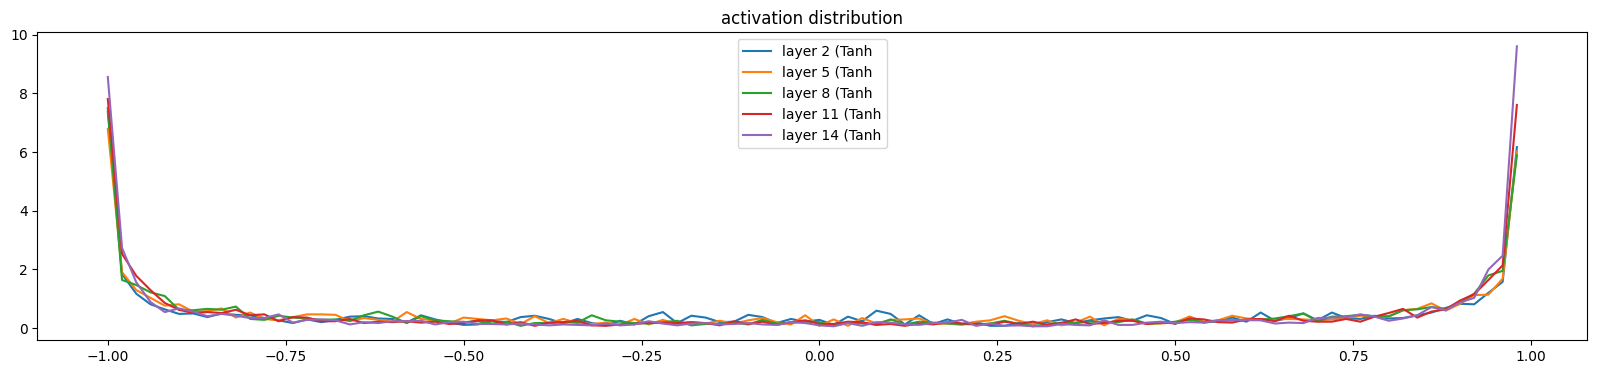

In [5]:
# visualize histograms of forward pass
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer (softmax)
  if isinstance(layer, Tanh): 
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.664794e-03
layer 5 (      Tanh): mean +0.000000, std 4.380601e-03
layer 8 (      Tanh): mean +0.000000, std 3.639203e-03
layer 11 (      Tanh): mean +0.000000, std 3.093999e-03
layer 14 (      Tanh): mean +0.000000, std 3.617025e-03


Text(0.5, 1.0, 'gradient distribution')

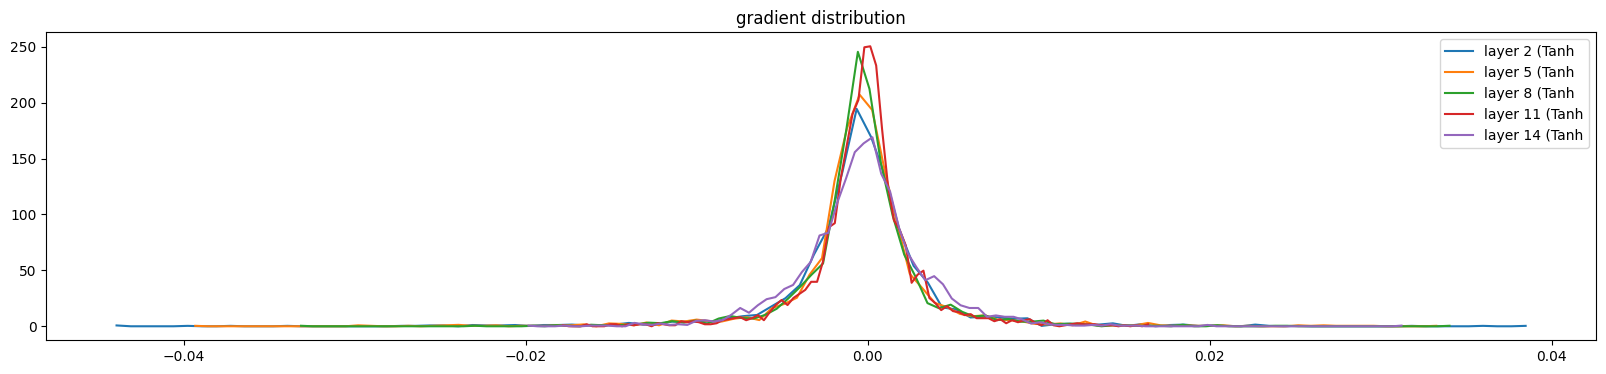

In [6]:
# visualize histograms of backward pass
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.314746e-03 | grad:data ratio 2.558055e-03
weight  (30, 100) | mean +0.000025 | std 3.015203e-03 | grad:data ratio 1.855981e-03
weight (100, 100) | mean +0.000008 | std 1.656788e-03 | grad:data ratio 1.407343e-03
weight (100, 100) | mean +0.000026 | std 1.452139e-03 | grad:data ratio 1.249773e-03
weight (100, 100) | mean -0.000014 | std 1.195233e-03 | grad:data ratio 1.052048e-03
weight (100, 100) | mean +0.000020 | std 1.034749e-03 | grad:data ratio 9.254620e-04
weight  (100, 27) | mean +0.000001 | std 2.150286e-03 | grad:data ratio 1.521201e-03


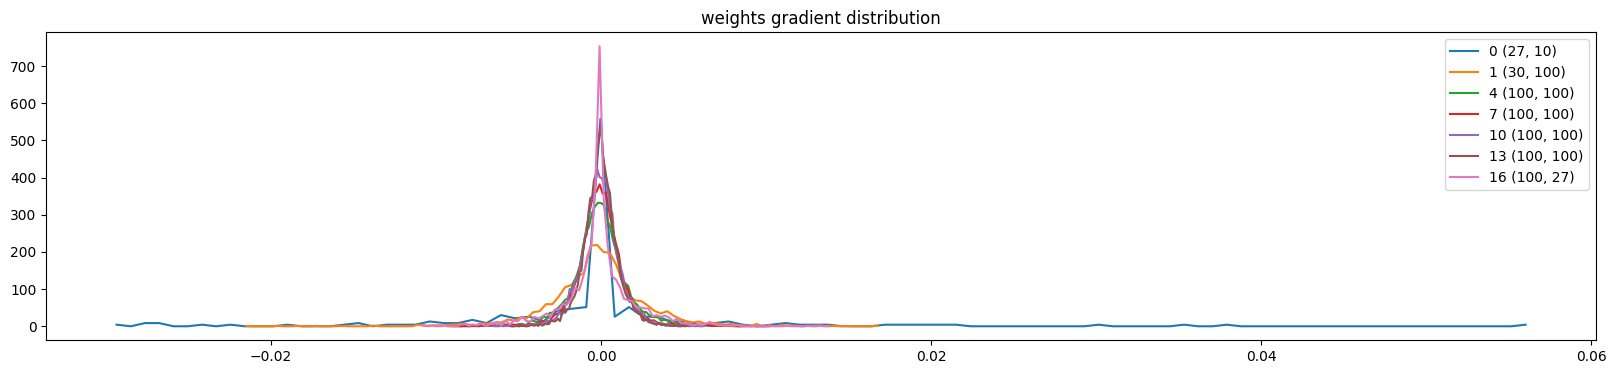

In [7]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

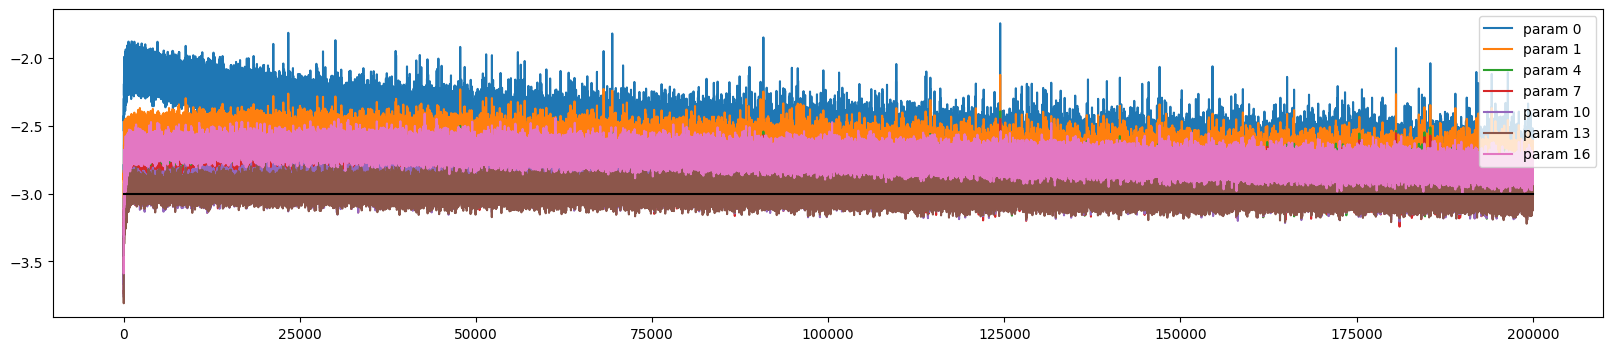

In [8]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot, if values are below this that means lr is way too small
plt.legend(legends);

In [13]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  #print(split, loss.item())
  return loss

# put layers into eval mode
for layer in layers:
  layer.training = False

lossT = split_loss('train')
lossD = split_loss('val')
lossAll = "Losses @ Training & Validation Sets: " + f'{lossT.item():.4f}' + " & " +  f'{lossD.item():.4f}'
print(lossAll)

Losses @ Training & Validation Sets: 2.0705 & 2.1355


In [16]:
#sampling

#sample 10 time for maximum quality
bestquality = 0.0
bestgenwords = ""
bestcountexct = 0

for rand in range(11):
    g = torch.Generator().manual_seed(2147483647+rand)

    generation = []
    numberofgen = 20
    for i in range(numberofgen):

        out = []
        context = [0] * block_size #start with dot

        while True:
            # forward pass the neural net
            emb = C[torch.tensor([context], device=device)] # (1,block_size,n_embd)
            x = emb.view(emb.shape[0], -1) # concatenate the vectors
            for layer in layers:
                x = layer(x)
            logits = x
            probs = F.softmax(logits, dim=1)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            # shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)
            # if we sample the special '.' token, break
            if ix == 0:
                break

        generated = ''.join(itos[i] for i in out).rstrip(".")
        generation.append(generated) 

    #find the words which already existed in the training set
    genwords = ""
    countexct = 0
    #c = [0 for x in range(0, len(generation))] #just marking the index
    for i, x in enumerate(generation):
        if len(genwords) > 0:
            genwords += ", "

        genwords += x

        if x in words[:n1]:
            #c[i] = 1
            countexct += 1
            genwords += "+"

    quality = (100*(1.0 - float(countexct)/float(numberofgen)))

    if quality > bestquality:
        bestgenwords = genwords
        bestcountexct = countexct
        bestquality = quality

bestcount = str(bestcountexct) + " no. (+ marked) generated words are exact copies from the training set; uniqueness score " + str(numberofgen-bestcountexct) + "/" + str(numberofgen) + ", " + f'{bestquality:.0f}' + "%."

#Markdown output
from IPython.display import display, Markdown, Latex
output = """\

## Output with optimised batch normalisation

Below setup with `{parameters}`no. parameters, results in Losses of ~`{lossT}` for training / ~`{lossD}` for dev/validation data sets:

`block_size = {block_size} | n_embd = {n_embd} | n_hidden = {n_hidden} | batch_size = {batch_size} | max_steps = {max_steps}`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~{bestquality}%** and other stats as follows:

| First Run|
|---|
| {bestgen1} |
| {bestcount1} |
| {loss1} |
<hr/>
""".format(
    parameters=sum(p.nelement() for p in parameters),
    lossT=f'{lossT:.4f}',
    lossD=f'{lossD:.4f}',
    block_size = block_size,
    n_embd = n_embd,
    n_hidden = n_hidden,
    batch_size = batch_size,
    max_steps = max_steps, 
    bestquality = f'{bestquality:.0f}',
    bestgen1 = bestgenwords,
    bestcount1 = bestcount,
    loss1 = lossAll,
)
display(Markdown(output))



## Output with optimised batch normalisation

Below setup with `47024`no. parameters, results in Losses of ~`2.0705` for training / ~`2.1355` for dev/validation data sets:

`block_size = 3 | n_embd = 10 | n_hidden = 100 | batch_size = 32 | max_steps = 200000`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~95%** and other stats as follows:

| First Run|
|---|
| shemnevonte, eus, asie, yaseluca, der, ludie, zavie, edo, tarrajioharzion, davon, keevayef, darzanz, maker, stephon+, kola, blon, lila, lilando, shays, ameryx |
| 1 no. (+ marked) generated words are exact copies from the training set; uniqueness score 19/20, 95%. |
| Losses @ Training & Validation Sets: 2.0705 & 2.1355 |
<hr/>


## Output after batch normalisation

Below setup with `12097`no. parameters, results in Losses of ~`2.0674` for training / ~`2.1057` for dev/validation data sets:

`block_size = 3 | n_embd = 10 | n_hidden = 200 | batch_size = 32 | max_steps = 200000`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~95%** and other stats as follows:

| First Run|
|---|
| jazque, tahannevan, shaseylynn, kanielladi, doneia, berleiveikarlonie, nehrenufayla, katian, alayja+, alinn, bleigh, fgraeleohawn, ashima, ellona, kaiselylon, eslyn, adda, kreelaiyah, avuya, astbel |
| 1 no. (+ marked) generated words are exact copies from the training set; uniqueness score 19/20, 95%. |
| Losses @ Training & Validation Sets: 2.0674 & 2.1057 |
<hr/>

## Output from pre-batch normalisation but with optimised weights

Below setup with `11897`no. parameters, results in Losses of ~`2.0377` for training / ~`2.1070` for dev/validation data sets:

`block_size = 3 | n_embd = 10 | n_hidden = 200 | batch_size = 32 | max_steps = 200000`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~95%** and other stats as follows:

| First Run|
|---|
| trevne, ory, kens, asie, yasia, zahmer, luzihira, mechesataraviel, krison, dani+, sate, raell, ceranz, makermit, dezicko, mubelle, praplionna, ari, grachmira, dar |
| 1 no. (+ marked) generated words are exact copies from the training set; uniqueness score 19/20, 95%. |
| Losses @ Training & Validation Sets: 2.0377 & 2.1070 |
<hr/>


## Output from AI9 notebook

Below setup with `11897`no. parameters, results in Losses of ~`2.0356` for training / ~`2.1027` for dev/validation data sets:

`block_size = 3 | n_embd = 10 | n_hidden = 200 | batch_size = 32 | max_steps = 200000`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~95%** and other stats as follows:

| First Run|
|---|
| dex, mariah, makilah, tyhammonie, traine, kayk, kata, kreez, pebutharminton, moriella, kinzleed, akareedensedey, niavion, rosbur, hunaven, tahiro, kaspe, breen, hayah, isa+ |
| 1 no. (+ marked) generated words are exact copies from the training set; uniqueness score 19/20, 95%. |
| Losses @ Training & Validation Sets: 2.0356 & 2.1027 |
<hr/>